In [112]:
from sklearn import metrics
import duckdb
import numpy as np

con = duckdb.connect("database.db", read_only=True)
jaccard = metrics.DistanceMetric.get_metric('jaccard')
cosine_distances = metrics.pairwise.cosine_distances

In [ ]:
genres_df = con.sql("SELECT spotify_id, name, genre from artists LEFT JOIN artist_genre ON artists.spotify_id=artist_genre.artist_id ORDER BY spotify_id ASC").df()
tags_df = con.sql("SELECT spotify_id, name, tag, weight from artists LEFT JOIN artist_tag ON artists.mbid=artist_tag.mbid ORDER BY spotify_id ASC").df()

In [165]:
# building the distance matrix from jaccard metric on genres
all_genres = con.sql("SELECT DISTINCT genre from artist_genre").df()["genre"].to_list()
spotify_ids = genres_df["spotify_id"].unique().tolist()
spotify_ids.sort()
genre_features = []
for spotify_id in spotify_ids:
    artist_genres = con.execute(f"SELECT genre from artist_genre WHERE artist_id = ?", (spotify_id,)).df()["genre"].to_list()
    genre_features.append([g in artist_genres for g in all_genres])

genre_features = np.array(genre_features)
genre_matrix = jaccard.pairwise(genre_features, genre_features)
print(genre_features.shape)

(365, 160)


In [ ]:
tag_features = tags_df.pivot(index="spotify_id", columns="tag", values="weight").fillna(0).to_numpy()
tag_matrix = cosine_distances(tag_features, tag_features)
print(tag_features.shape)

(365, 618)


In [166]:
distance_matrix = (genre_matrix + tag_matrix) / 2

In [ ]:
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

kmeans = KMeans(n_clusters=10)
colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']

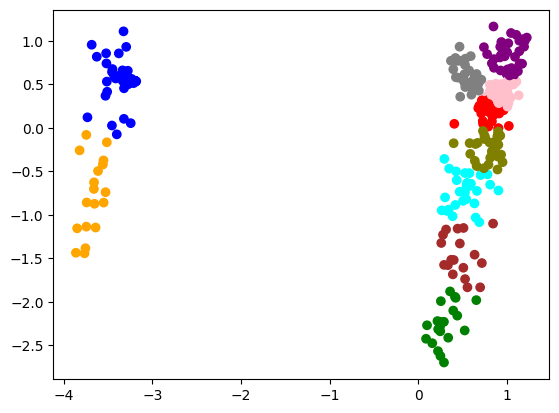

In [168]:
pca = PCA(n_components=2)
pca_coords = pca.fit_transform(distance_matrix)
pca_labels = kmeans.fit(pca_coords).labels_
plt.scatter(pca_coords[:,0], pca_coords[:,1], color=[colors[l] for l in pca_labels])
#for i, name in enumerate(names):
#    plt.annotate(name, (pca_coords[i,0], pca_coords[i,1]))

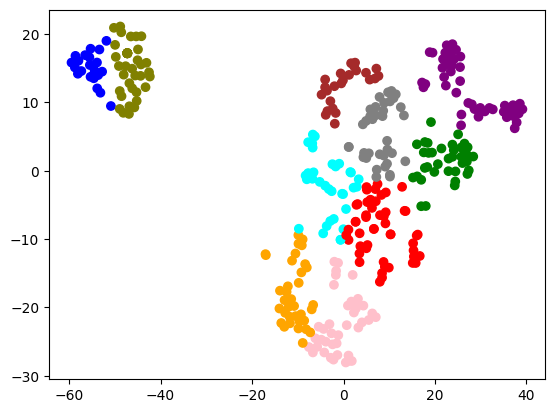

In [169]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2)
tsne_coords = tsne.fit_transform(distance_matrix)
tsne_labels = kmeans.fit(tsne_coords).labels_
plt.scatter(tsne_coords[:,0], tsne_coords[:,1], color=[colors[l] for l in tsne_labels])
#for i, name in enumerate(names):
#    plt.annotate(name, (tsne_coords[i,0], tsne_coords[i,1]))

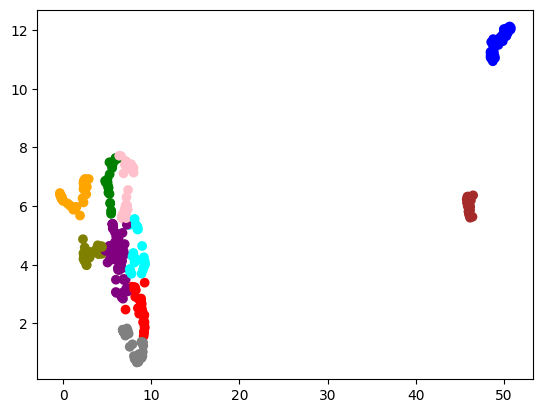

In [170]:
import umap
reducer = umap.UMAP(n_components=2)
umap_coords = reducer.fit_transform(distance_matrix)
umap_labels = kmeans.fit(umap_coords).labels_
plt.scatter(umap_coords[:,0], umap_coords[:,1], color=[colors[l] for l in umap_labels])
#for i, name in enumerate(names):
#    plt.annotate(name, (umap_coords[i,0], umap_coords[i,1]))

In [104]:
for i, name in enumerate(names):
    print(f"{name}: Cluster PCA-{pca_labels[i]}, TSNE-{tsne_labels[i]}, UMAP-{umap_labels[i]}")

100%: Cluster PCA-5, TSNE-5, UMAP-5
AURORA: Cluster PCA-0, TSNE-6, UMAP-8
Abul Mogard: Cluster PCA-4, TSNE-8, UMAP-7
Acid Ghost: Cluster PCA-8, TSNE-5, UMAP-1
Acid Row: Cluster PCA-0, TSNE-4, UMAP-4
Afrorack: Cluster PCA-4, TSNE-6, UMAP-8
Agalloch: Cluster PCA-8, TSNE-4, UMAP-2
Aho Ssan: Cluster PCA-4, TSNE-8, UMAP-7
Akaitsuki: Cluster PCA-1, TSNE-0, UMAP-9
Alcest: Cluster PCA-6, TSNE-0, UMAP-9
Alice In Chains: Cluster PCA-0, TSNE-7, UMAP-0
Amnesia Scanner: Cluster PCA-4, TSNE-8, UMAP-8
Ana Roxanne: Cluster PCA-4, TSNE-8, UMAP-7
Animal Collective: Cluster PCA-0, TSNE-9, UMAP-6
Aphex Twin: Cluster PCA-4, TSNE-8, UMAP-7
Arca: Cluster PCA-4, TSNE-6, UMAP-8
Arcade Fire: Cluster PCA-0, TSNE-7, UMAP-5
Argo Nuff: Cluster PCA-5, TSNE-5, UMAP-5
Asian Glow: Cluster PCA-2, TSNE-5, UMAP-1
Asking Alexandria: Cluster PCA-0, TSNE-3, UMAP-5
Astrid Sonne: Cluster PCA-4, TSNE-8, UMAP-7
Bad Omens: Cluster PCA-0, TSNE-3, UMAP-5
Bark Psychosis: Cluster PCA-9, TSNE-5, UMAP-1
Barker: Cluster PCA-4, TSNE-8, U